## Import libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import os
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold,cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,classification_report
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


## Import and analyze dataset

In [6]:
fwi_dataset=pd.read_csv("./fwi_dataset_lecce.csv")

In [7]:
fwi_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15339 entries, 0 to 15338
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       15339 non-null  object 
 1   longitude  15339 non-null  float64
 2   latitude   15339 non-null  float64
 3   tp         15339 non-null  float64
 4   u10        15339 non-null  float64
 5   v10        15339 non-null  float64
 6   r          15339 non-null  float64
 7   t2m        15339 non-null  float64
 8   fwi        15339 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.1+ MB


In [8]:
fwi_dataset.describe()

,longitude,latitude,tp,u10,v10,r,t2m,fwi
count,15339.00,15339.0,1.533900e+04,15339.000000,15339.000000,15339.000000,15339.000000,1.533900e+04
mean,18.25,40.5,1.813084e-03,0.294165,-0.605066,68.368336,291.030020,1.191900e+01
std,0.00,0.0,4.823592e-03,1.756465,3.709951,11.773074,6.154736,1.198779e+01
min,18.25,40.5,-4.470348e-08,-7.643942,-12.242251,17.842276,273.901860,1.728386e-09
25%,18.25,40.5,5.587935e-09,-0.768009,-3.444192,60.605659,285.929440,2.054504e+00
50%,18.25,40.5,8.502696e-05,0.308107,-1.165552,69.276830,290.383330,7.535400e+00
75%,18.25,40.5,1.050394e-03,1.456307,2.126963,77.129482,296.467270,1.976184e+01
max,18.25,40.5,8.191778e-02,8.034882,11.399133,97.379600,306.962740,9.205359e+01


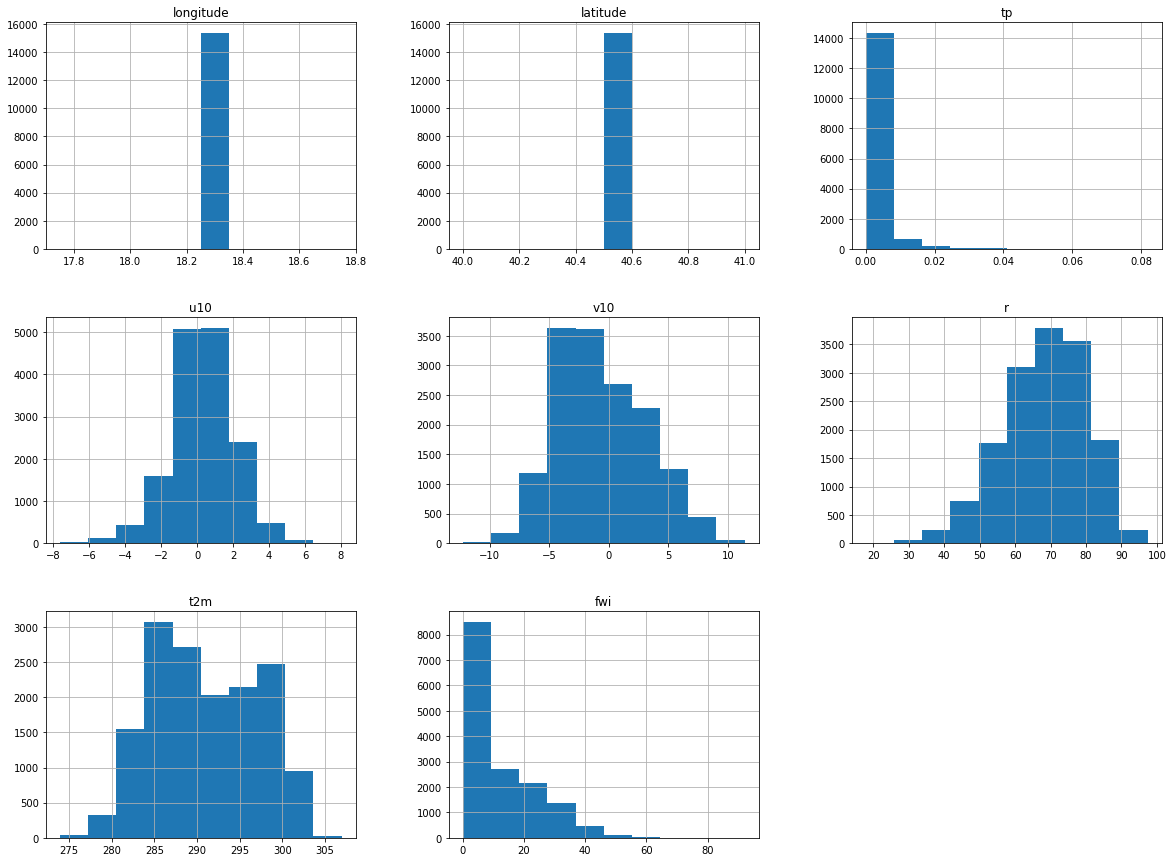

In [9]:
fwi_dataset.hist(figsize=(20,15))
plt.show()

### Feature adjustment

In [10]:
#Aggiunta feature per il livello di danger
fwi_dataset["danger"] = pd.cut(fwi_dataset["fwi"],
                                bins=[0, 5, 10, 20, 30, np.inf],
                                labels=["low","moderate","high","very high","extreme"])

In [11]:
fwi_dataset["danger"].value_counts() / len(fwi_dataset)

low          0.399439
high         0.179934
moderate     0.175370
very high    0.146359
extreme      0.098898
Name: danger, dtype: float64

In [35]:
from firedanger import firedanger

firedanger.calc_canadian_fwi(5,43,0,15,8)

0.1992959123802073

In [12]:
#Aggiunta colonne anno, mese e giorno
dateFormatter = "%Y-%m-%d %H:%M:%S"

ids = fwi_dataset["time"]
time_transformed=ids.apply(lambda x:pd.to_datetime(x,format=dateFormatter))

ids= time_transformed
years = ids.apply(lambda x:x.year)
months=ids.apply(lambda x:x.month)

fwi_dataset.insert(1,"year",years,allow_duplicates=False)
fwi_dataset.insert(1,"month",months,allow_duplicates=False)

In [9]:
#Aggiungere colonna velocità vento [m/s]
fwi_dataset["ws"]=np.sqrt((fwi_dataset["u10"]**2)+(fwi_dataset["v10"]**2))

In [10]:
#Temperatura in Celsius
fwi_dataset["t2m"]=fwi_dataset["t2m"]-273.15

#Precipitazioni in mm
fwi_dataset["tp"]=fwi_dataset["tp"]*1000

In [11]:
fwi_dataset.describe()

,month,year,longitude,latitude,tp,u10,v10,r,t2m,fwi,ws
count,15339.000000,15339.000000,15339.00,15339.0,15339.000000,15339.000000,15339.000000,15339.000000,15339.000000,1.533900e+04,15339.000000
mean,6.523502,1999.503031,18.25,40.5,1.813084,0.294165,-0.605066,68.368336,17.880020,1.191900e+01,3.635512
std,3.448504,12.120238,0.00,0.0,4.823592,1.756465,3.709951,11.773074,6.154736,1.198779e+01,2.020831
min,1.000000,1979.000000,18.25,40.5,-0.000045,-7.643942,-12.242251,17.842276,0.751860,1.728386e-09,0.032648
25%,4.000000,1989.000000,18.25,40.5,0.000006,-0.768009,-3.444192,60.605659,12.779440,2.054504e+00,2.068065
50%,7.000000,2000.000000,18.25,40.5,0.085027,0.308107,-1.165552,69.276830,17.233330,7.535400e+00,3.389468
75%,10.000000,2010.000000,18.25,40.5,1.050394,1.456307,2.126963,77.129482,23.317270,1.976184e+01,4.918192
max,12.000000,2020.000000,18.25,40.5,81.917780,8.034882,11.399133,97.379600,33.812740,9.205359e+01,13.164901


Text(0.5, 1.0, 'Tp')

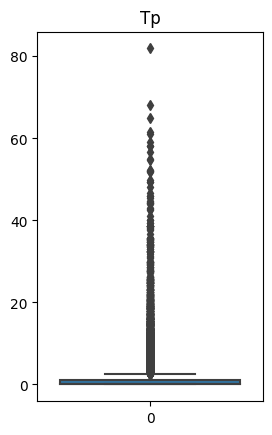

In [12]:
plt.subplot(1, 2, 1)
sns.boxplot(data=fwi_dataset["tp"])
plt.title('Tp')

### Other indexes

In [13]:
#Aggiunta indici riguardanti FWI
from firedanger import indices

t2m_ix, p_ix, h_ix, m_ix,w_ix= 9,5,8,1,12

array=np.array(fwi_dataset)
dc_list=[]
dmc_list=[]
ffmc_list=[]
isi_list=[]
bui_list=[]
dc,dmc,ffmc=15,6,85

for i in array:
    dc=indices.dc(i[t2m_ix],i[p_ix],i[m_ix],40.5,dc)
    dc_list.append(dc)
    dmc=indices.dmc(i[t2m_ix],i[p_ix],i[h_ix],i[m_ix],40.5,dmc)
    dmc_list.append(dmc)
    ffmc=indices.ffmc(i[t2m_ix],i[p_ix],i[w_ix],i[h_ix],ffmc)
    ffmc_list.append(ffmc)
    isi=indices.isi(i[w_ix],ffmc)
    isi_list.append(isi)
    bui=indices.bui(dmc,dc)
    bui_list.append(bui)
    

fwi_dataset["dc"]=dc_list
fwi_dataset["dmc"]=dmc_list
fwi_dataset["ffmc"]=ffmc_list
fwi_dataset["isi"]=isi_list
fwi_dataset["bui"]=bui_list

/Users/pierluigicosi/Desktop/Università/Magistrale/Artificial intelligence app/ml/env/lib/python3.10/site-packages/firedanger/indices.py:834: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: Union[int, float], mth: int):  # Union[int, float]
/Users/pierluigicosi/Desktop/Università/Magistrale/Artificial intelligence app/ml/env/lib/python3.10/site-packages/firedanger/indices.py:853: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecat

In [14]:
#Modifico cat in ordinal

oe=OrdinalEncoder(categories=[["low","moderate","high","very high","extreme"]])
fwi_dataset["danger"]=oe.fit_transform(fwi_dataset[["danger"]])

In [ ]:
fwi_dataset.describe()

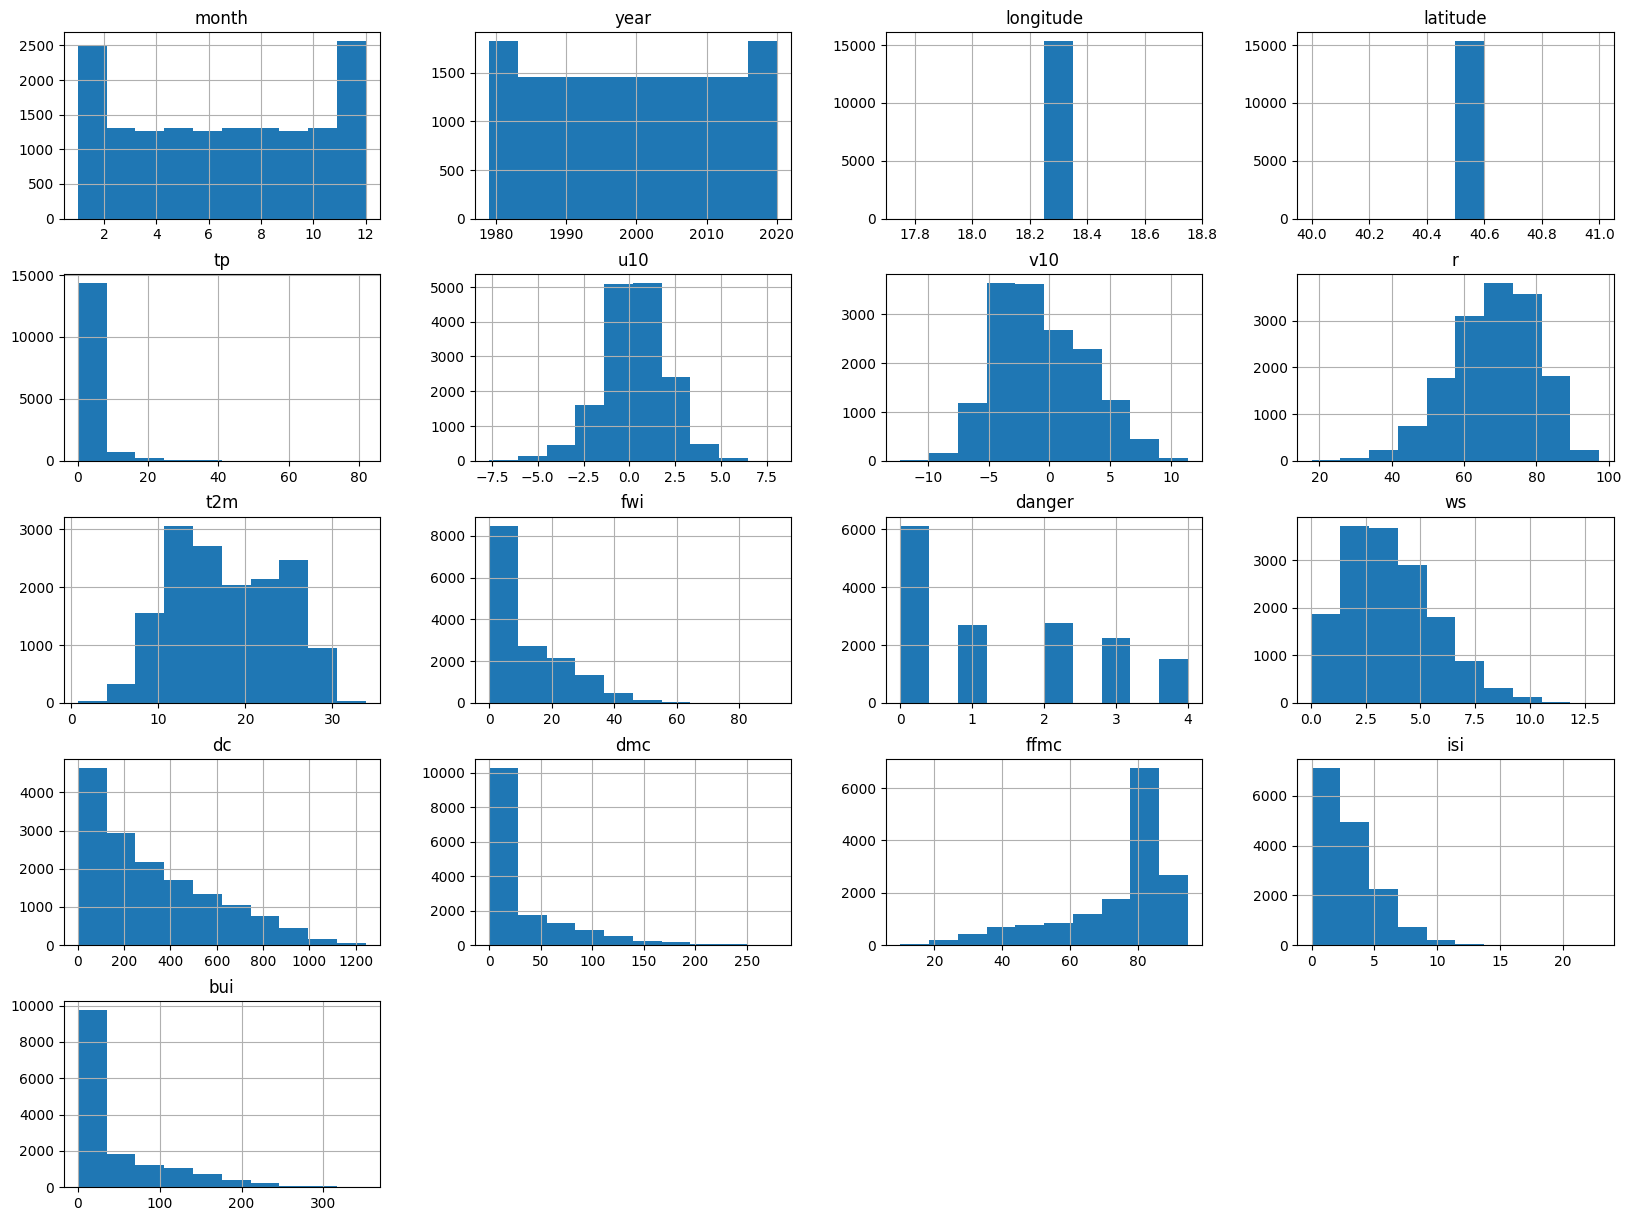

In [15]:
fwi_dataset.hist(figsize=(20,15))
plt.show()

### Correlations analysis

In [16]:
cor = fwi_dataset.corr(numeric_only=True)
cor["danger"].sort_values(ascending=False)

danger       1.000000
fwi          0.956380
bui          0.798694
dmc          0.777299
isi          0.766749
t2m          0.757108
dc           0.653573
ffmc         0.626733
month        0.138359
u10          0.117147
ws           0.060883
year        -0.026886
v10         -0.178914
tp          -0.320401
r           -0.421269
longitude         NaN
latitude          NaN
Name: danger, dtype: float64

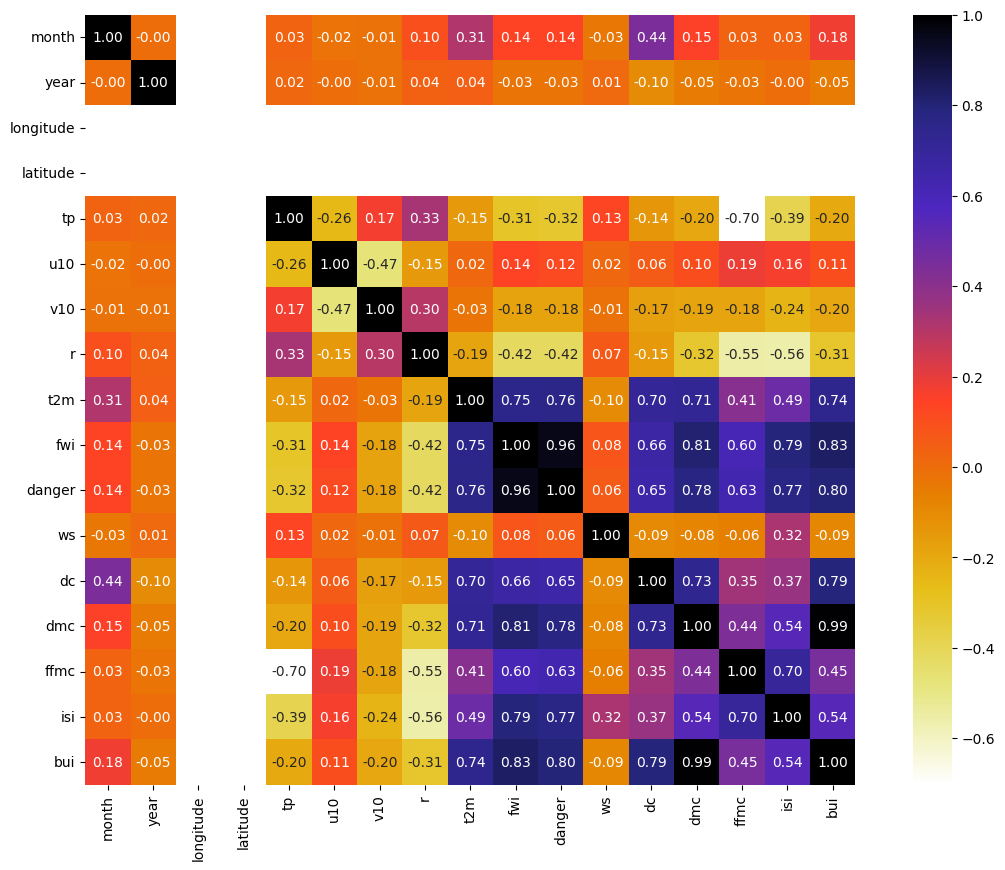

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(cor, annot=True, square=True,cmap=plt.cm.CMRmap_r,fmt='.2f')
plt.show()

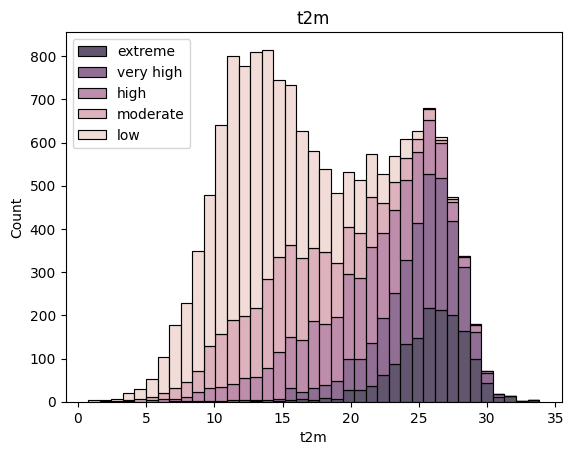

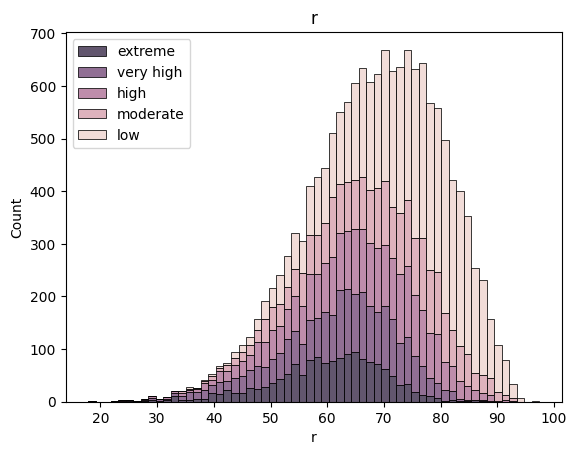

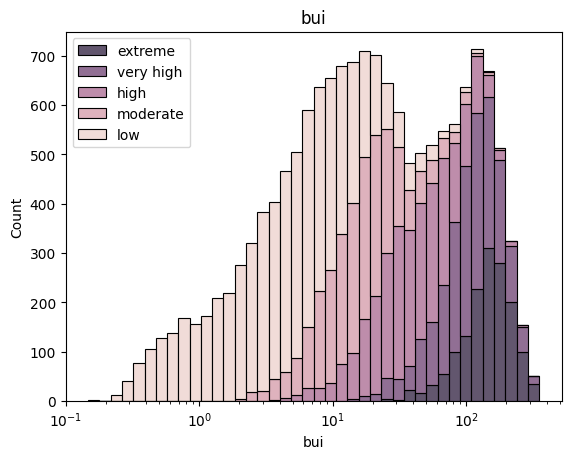

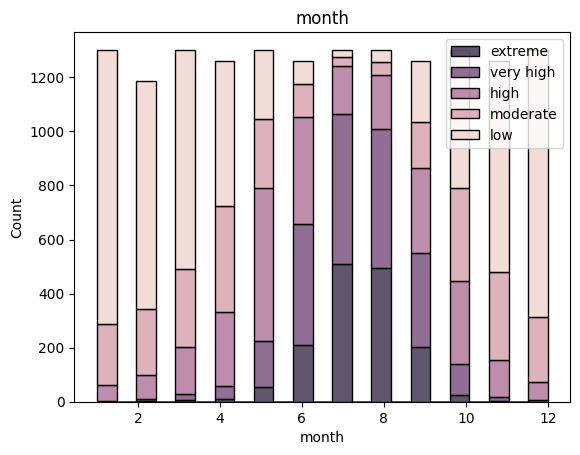

In [18]:
dftemp = fwi_dataset[['t2m','r','bui','month']]
for feature in dftemp:
    if feature=="bui":
        sns.histplot(data = dftemp,x=feature, hue = fwi_dataset['danger'],multiple="stack",log_scale=True)
    else:
        sns.histplot(data = dftemp,x=feature, hue = fwi_dataset['danger'],multiple="stack")
    plt.legend(labels=["extreme",'very high',"high","moderate","low"])
    plt.title(feature)
    plt.show()

In [ ]:
#fwi_dataset.to_csv("fwi_dataset_augmented.csv",index=False)

# Classificazione Multiclasse

## Train Test Split

In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(fwi_dataset, fwi_dataset["danger"]):
        strat_train_set = fwi_dataset.loc[train_index]
        strat_test_set = fwi_dataset.loc[test_index]
        
X_strat_train_set=strat_train_set.drop(['danger','fwi'],axis=1)
y_strat_train_set=strat_train_set["danger"].copy()
X_strat_test_set=strat_test_set.drop(['danger','fwi'],axis=1)
y_strat_test_set=strat_test_set["danger"].copy()

In [20]:
X_strat_train_set=X_strat_train_set.drop(['time','latitude','longitude','year'],axis=1)
X_strat_test_set=X_strat_test_set.drop(['time','latitude','longitude','year'],axis=1)

## Pipeline

In [21]:
from sklearn.compose import ColumnTransformer

pipeline=Pipeline(steps=[
    ("std",StandardScaler())
])

X_train_scaled=pipeline.fit_transform(X_strat_train_set)
X_test_scaled=pipeline.transform(X_strat_test_set)

Text(0.5, 1.0, 'X_train After Scaling')

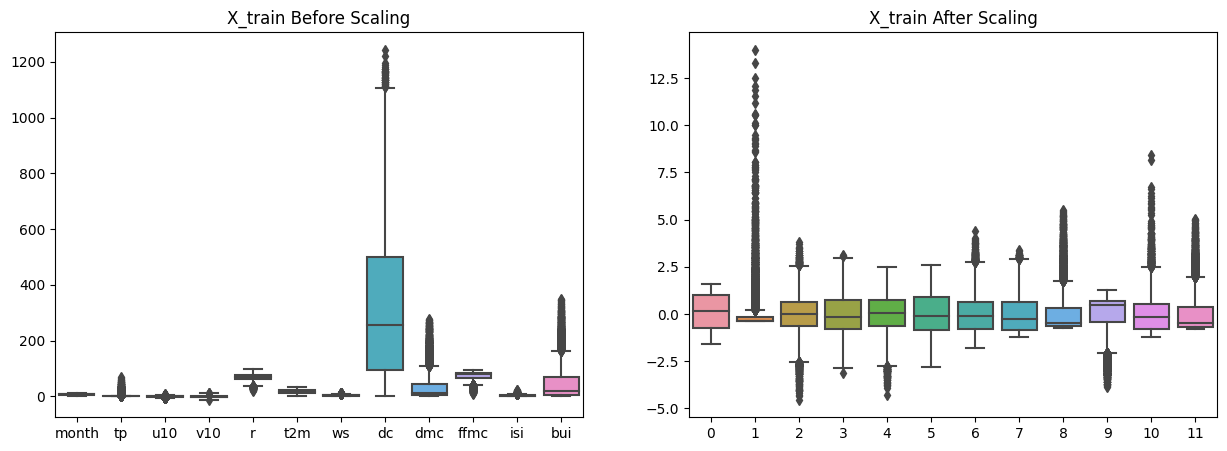

In [22]:
#boxplot per mostrare i quartili

plt.subplots(figsize=(15, 5))
plt.clf()
plt.subplot(1, 2, 1)
sns.boxplot(data=X_strat_train_set)
plt.title('X_train Before Scaling')
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled)
plt.title('X_train After Scaling')

## Train

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [24]:
#Funzione per la roc_auc score
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creo un set di tutte le classi usando la class list
    unique_class = set(actual_class)
    roc_auc_dict = []
    for per_class in unique_class:
        
        other_class = [x for x in unique_class if x != per_class]

        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #calcolo la roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class)
        roc_auc_dict.append(roc_auc)

    return np.mean(roc_auc_dict)

In [25]:
def print_results(set,prediction):
    cr=classification_report(set,prediction)
    roc=roc_auc_score_multiclass(set,prediction)
    
    print("ROC:",roc)
    print (cr)
    
    cm=confusion_matrix(set,prediction)
    ConfusionMatrixDisplay(cm).plot()

### Dummy

ROC: 0.4985056690927926
              precision    recall  f1-score   support

         0.0       0.40      0.41      0.41      4901
         1.0       0.17      0.17      0.17      2152
         2.0       0.18      0.17      0.17      2208
         3.0       0.14      0.14      0.14      1796
         4.0       0.10      0.10      0.10      1214

    accuracy                           0.25     12271
   macro avg       0.20      0.20      0.20     12271
weighted avg       0.25      0.25      0.25     12271



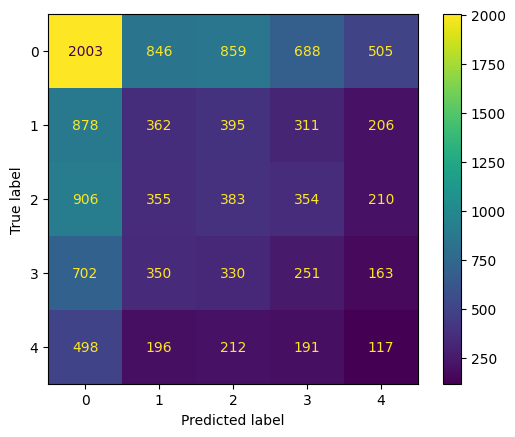

In [26]:
dmy_clf = DummyClassifier(strategy="stratified")

dmy_clf.fit(X_strat_train_set,y_strat_train_set)

dummy_predict = dmy_clf.predict(X_train_scaled)

print_results(y_strat_train_set,dummy_predict)

### Nonlinear SVC

In [27]:
skfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

lin_clf=SVC(random_state=42,kernel="rbf")

lin_clf.fit(X_train_scaled,y_strat_train_set)

lin_predict = cross_val_predict(lin_clf, X_train_scaled, y_strat_train_set, cv=skfold)

SVC
ROC: 0.8250084899792751
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      4901
         1.0       0.61      0.62      0.62      2152
         2.0       0.69      0.67      0.68      2208
         3.0       0.66      0.71      0.68      1796
         4.0       0.82      0.64      0.72      1214

    accuracy                           0.76     12271
   macro avg       0.73      0.71      0.72     12271
weighted avg       0.76      0.76      0.76     12271



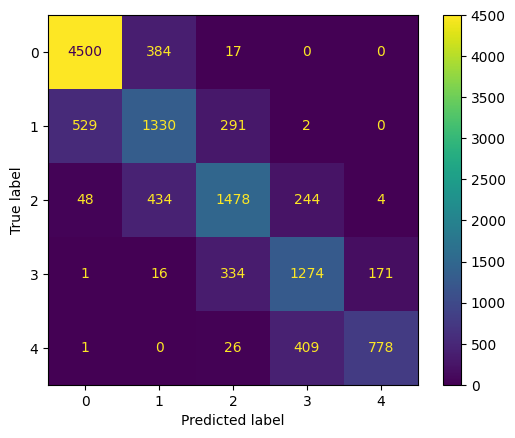

In [28]:
print("SVC")
print_results(y_strat_train_set,lin_predict)

### Decision Tree

In [29]:
tree_clf=DecisionTreeClassifier(random_state=42)

tree_clf.fit(X_train_scaled,y_strat_train_set)

tree_prediction = cross_val_predict(tree_clf, X_train_scaled, y_strat_train_set,cv=skfold)

In [30]:
features=X_strat_train_set.columns
classes=["low","moderate","high","very high","extreme"]

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(os.curdir, "danger.dot"),
        feature_names=features,
        class_names=classes,
        rounded=True,
        filled=True
        )

Decision Tree
ROC: 0.7743643079026741
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      4901
         1.0       0.52      0.51      0.51      2152
         2.0       0.56      0.57      0.56      2208
         3.0       0.56      0.58      0.57      1796
         4.0       0.66      0.63      0.64      1214

    accuracy                           0.68     12271
   macro avg       0.63      0.63      0.63     12271
weighted avg       0.68      0.68      0.68     12271



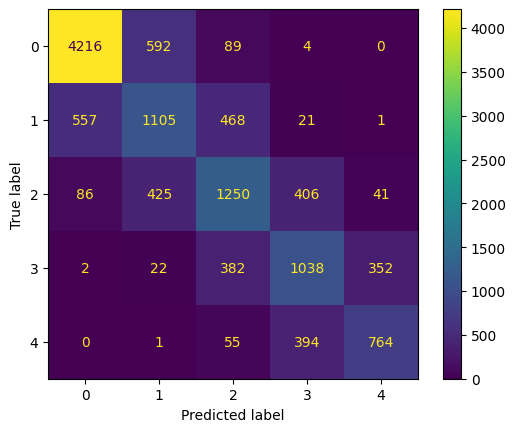

In [31]:
print("Decision Tree")
print_results(y_strat_train_set,tree_prediction)

### Random Forest

In [32]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_strat_train_set)

rf_prediction = cross_val_predict(rf_clf, X_train_scaled, y_strat_train_set,cv=skfold)

Random Forest
ROC: 0.8220159011287773
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      4901
         1.0       0.61      0.61      0.61      2152
         2.0       0.68      0.68      0.68      2208
         3.0       0.65      0.68      0.67      1796
         4.0       0.78      0.64      0.71      1214

    accuracy                           0.76     12271
   macro avg       0.72      0.71      0.71     12271
weighted avg       0.76      0.76      0.76     12271



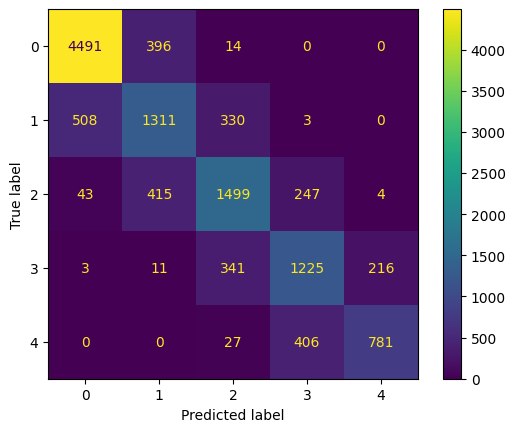

In [33]:
print("Random Forest")
print_results(y_strat_train_set,rf_prediction)

### XGBoost

In [34]:
xgb_clf = XGBClassifier(random_state=42,objective='multi:softmax')
xgb_clf.fit(X_train_scaled, y_strat_train_set)

xgb_prediction = cross_val_predict(xgb_clf, X_train_scaled, y_strat_train_set,cv=skfold)

XGBoost
ROC: 0.8186980918423353
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      4901
         1.0       0.60      0.59      0.59      2152
         2.0       0.66      0.66      0.66      2208
         3.0       0.65      0.67      0.66      1796
         4.0       0.76      0.68      0.71      1214

    accuracy                           0.75     12271
   macro avg       0.71      0.70      0.71     12271
weighted avg       0.75      0.75      0.75     12271



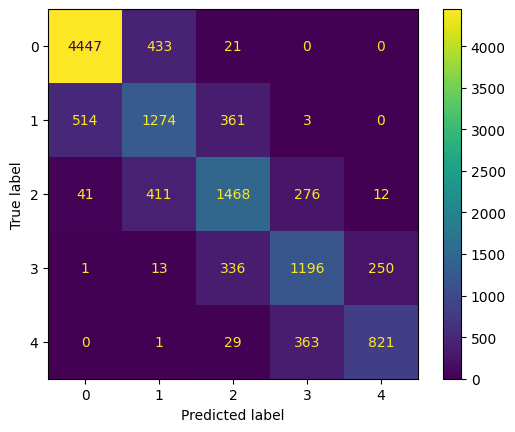

In [35]:
print("XGBoost")
print_results(y_strat_train_set,xgb_prediction)

## GridSearch

## Random forest

In [36]:
param_grid = [
        {'bootstrap':[True],'n_estimators': [200,300], 'max_depth': [20,30],
         'criterion':['entropy','gini'],'max_samples':[1000,2000]}  
]

rf_clf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=skfold,    
                               return_train_score=True,n_jobs=-1,scoring="f1_macro")

grid_search_rf.fit(X_train_scaled, y_strat_train_set)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'criterion': ['entropy', 'gini'],
                          'max_depth': [20, 30], 'max_samples': [1000, 2000],
                          'n_estimators': [200, 300]}],
             return_train_score=True, scoring='f1_macro')

In [37]:
best_rf = grid_search_rf.best_estimator_

grid_search_rf.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 30,
 'max_samples': 2000,
 'n_estimators': 300}

In [38]:
feature_importance=best_rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
importance_df

,feature,importance
8,dmc,0.170637
11,bui,0.158754
10,isi,0.156524
9,ffmc,0.105133
5,t2m,0.083121
7,dc,0.058723
6,ws,0.056691
3,v10,0.052011
1,tp,0.051164
2,u10,0.044843


BEST RF
ROC: 0.8253720565370966
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      4901
         1.0       0.62      0.61      0.62      2152
         2.0       0.69      0.69      0.69      2208
         3.0       0.66      0.69      0.68      1796
         4.0       0.80      0.65      0.71      1214

    accuracy                           0.76     12271
   macro avg       0.73      0.71      0.72     12271
weighted avg       0.76      0.76      0.76     12271



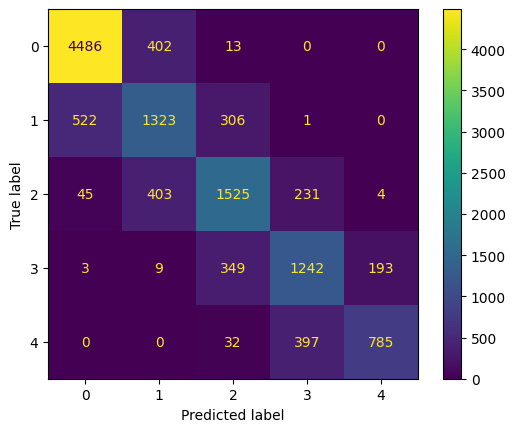

In [39]:
rf_best_pred = cross_val_predict(best_rf, X_train_scaled, y_strat_train_set,cv=skfold,n_jobs=-1)

print("BEST RF")
print_results(y_strat_train_set,rf_best_pred)

## XGB

In [40]:
param_grid={"learning_rate": [0.1,0.2],"max_depth": [5,7],"n_estimators":[100,150],"subsample":[0.5]}

xgb_clf = XGBClassifier(random_state=42,objective='multi:softmax')

grid_search_xgb = GridSearchCV(xgb_clf, param_grid, cv=skfold,scoring="f1_macro",    
                               return_train_score=True,n_jobs=-1)

grid_search_xgb.fit(X_train_scaled, y_strat_train_set)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [5, 7],
                         'n_estimators': [100, 150], 'subsample': [0.5]},
             return_train_score=True, scoring='f1_macro')

In [ ]:
best_xgb = grid_search_xgb.best_estimator_

grid_search_xgb.best_params_

In [ ]:
feature_importance=best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
importance_df

In [ ]:
xgb_best_pred = cross_val_predict(best_xgb, X_train_scaled, y_strat_train_set,cv=skfold,n_jobs=-1)

print("BEST XGB")
print_results(y_strat_train_set,xgb_best_pred)

## Threshold

In [41]:
def search_thresholds(proba,set):
    th=[]
    for i in range (0,5):
        
        np.seterr(divide='ignore', invalid='ignore')
        precision, recall, thresholds = precision_recall_curve(set, proba[:,i],pos_label=i)
        def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
            plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
            plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
            plt.legend(loc="center right", fontsize=16) 
            plt.xlabel("Threshold", fontsize=16)        
            plt.grid(True)                              
            plt.show()

        plot_precision_recall_vs_threshold(precision,recall,thresholds)
    
        f1 = 2 * ((precision * recall) / (precision + recall))

        #best threshold's index
        best_idx = np.argmax(f1)
        best_th=thresholds[best_idx]
        print(f'For class {i} the best possible threshold is {best_th:.3f} wich leads to f1={f1[best_idx]:.3f}')
        th.append(best_th)

        
    return th

In [42]:
def use_thresholds(proba,set,th):
    y_pred=np.zeros_like(set)
        
    y_pred = [4 if p[4]>th[4] else np.argmax(p) for p in proba] 
            
    
    print_results(set,y_pred) 

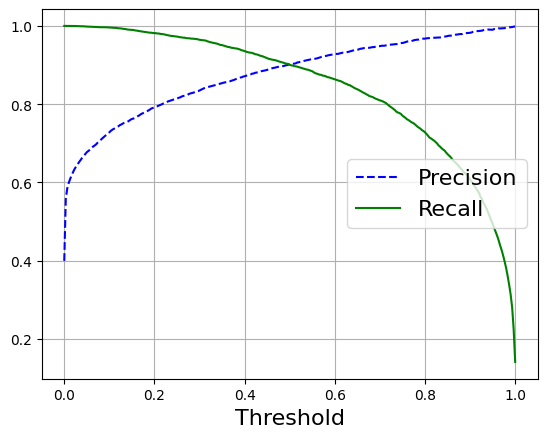

For class 0 the best possible threshold is 0.417 wich leads to f1=0.904


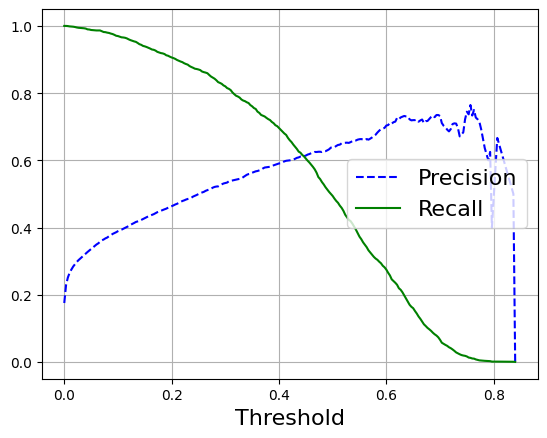

For class 1 the best possible threshold is 0.840 wich leads to f1=nan


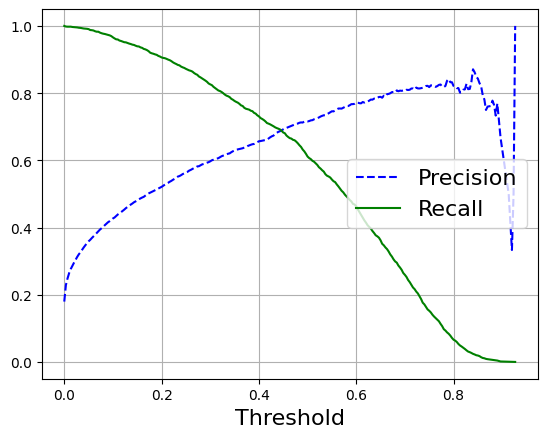

For class 2 the best possible threshold is 0.353 wich leads to f1=0.696


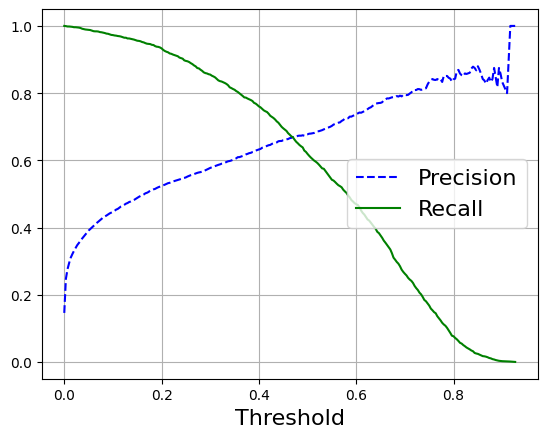

For class 3 the best possible threshold is 0.357 wich leads to f1=0.693


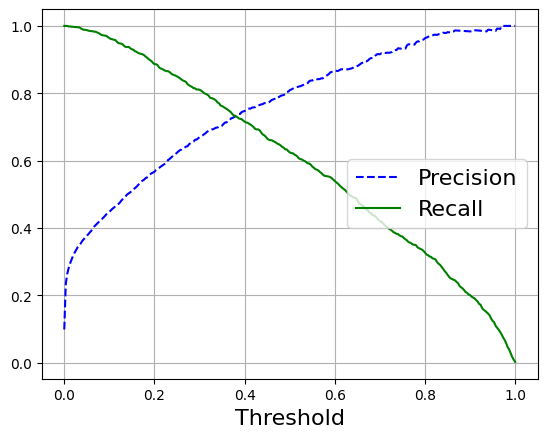

For class 4 the best possible threshold is 0.320 wich leads to f1=0.737


In [43]:
rf_best_proba = cross_val_predict(best_rf, X_train_scaled, y_strat_train_set,cv=skfold,method="predict_proba")

thresholds=search_thresholds(rf_best_proba,y_strat_train_set)

In [ ]:
use_thresholds(rf_best_proba,y_strat_train_set,thresholds)

## Test

In [ ]:
rf_pred = cross_val_predict(best_rf, X_test_scaled, y_strat_test_set,cv=3)

print("FINAL RF")
print_results(y_strat_test_set,rf_pred)

## Neural Network

In [44]:
root_logdir = os.path.join(os.curdir, "clf_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [45]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
es_scheduler=keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)

def build_model(n_hidden=3, n_neurons=80, learning_rate=0.02, input_shape=[12]):
    clf_model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        clf_model.add(keras.layers.Dense(n_neurons, activation="relu",kernel_initializer="normal", **options))
        options = {} 
    clf_model.add(keras.layers.Dense(5,activation="softmax",**options))
    optimizer = keras.optimizers.legacy.SGD(learning_rate)
    clf_model.compile(loss="categorical_crossentropy",
                      metrics=[tfa.metrics.F1Score(average='macro',num_classes=5)],optimizer=optimizer)
    return clf_model

model_clf=keras.wrappers.scikit_learn.KerasClassifier(build_model)


history=model_clf.fit(X_train_scaled, y_strat_train_set, epochs=100,
                  validation_split=0.2,
                  callbacks=[es_scheduler,lr_scheduler,tensorboard_cb])

Epoch 1/100


/Users/pierluigicosi/Desktop/Università/Magistrale/Artificial intelligence app/ml/env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/tmp/ipykernel_44224/3857176581.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_clf=keras.wrappers.scikit_learn.KerasClassifier(build_model)
2023-06-19 11:37:48.931441: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU fr

307/307 [==============================] - 0s 746us/step - loss: 1.3831 - f1_score: 0.1832 - val_loss: 1.0922 - val_f1_score: 0.4320 - lr: 0.0200
Epoch 2/100
307/307 [==============================] - 0s 508us/step - loss: 0.8602 - f1_score: 0.5287 - val_loss: 0.7533 - val_f1_score: 0.6028 - lr: 0.0200
Epoch 3/100
307/307 [==============================] - 0s 489us/step - loss: 0.6833 - f1_score: 0.6455 - val_loss: 0.6671 - val_f1_score: 0.6608 - lr: 0.0200
Epoch 4/100
307/307 [==============================] - 0s 523us/step - loss: 0.6271 - f1_score: 0.6823 - val_loss: 0.6359 - val_f1_score: 0.6768 - lr: 0.0200
Epoch 5/100
307/307 [==============================] - 0s 505us/step - loss: 0.6015 - f1_score: 0.6967 - val_loss: 0.6164 - val_f1_score: 0.6880 - lr: 0.0200
Epoch 6/100
307/307 [==============================] - 0s 494us/step - loss: 0.5859 - f1_score: 0.6990 - val_loss: 0.5986 - val_f1_score: 0.7031 - lr: 0.0200
Epoch 7/100
307/307 [==============================] - 0s 487us/

Epoch 53/100
307/307 [==============================] - 0s 491us/step - loss: 0.5106 - f1_score: 0.7367 - val_loss: 0.5444 - val_f1_score: 0.7247 - lr: 0.0025
Epoch 54/100
307/307 [==============================] - 0s 488us/step - loss: 0.5100 - f1_score: 0.7373 - val_loss: 0.5425 - val_f1_score: 0.7298 - lr: 0.0025
Epoch 55/100
307/307 [==============================] - 0s 489us/step - loss: 0.5102 - f1_score: 0.7389 - val_loss: 0.5482 - val_f1_score: 0.7253 - lr: 0.0025
Epoch 56/100
307/307 [==============================] - 0s 490us/step - loss: 0.5103 - f1_score: 0.7365 - val_loss: 0.5423 - val_f1_score: 0.7250 - lr: 0.0025
Epoch 57/100
307/307 [==============================] - 0s 492us/step - loss: 0.5097 - f1_score: 0.7367 - val_loss: 0.5458 - val_f1_score: 0.7250 - lr: 0.0025
Epoch 58/100
307/307 [==============================] - 0s 489us/step - loss: 0.5101 - f1_score: 0.7375 - val_loss: 0.5432 - val_f1_score: 0.7262 - lr: 0.0025
Epoch 59/100
307/307 [========================

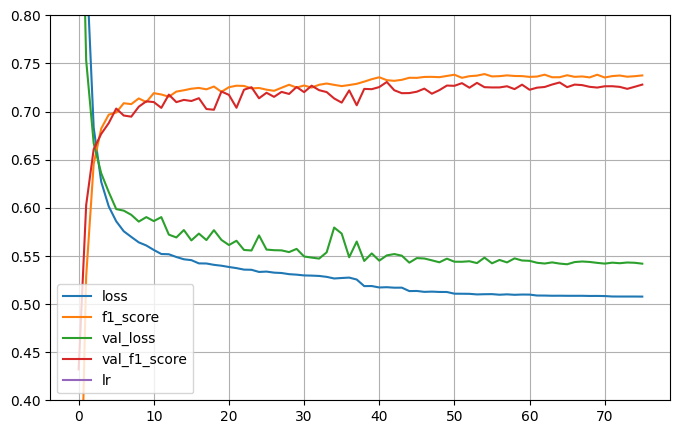

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 0.8)
plt.show()

In [ ]:
model_clf.model.summary()

96/96 [==============================] - 0s 272us/step
Final
ROC: 0.829358624346454
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1226
         1.0       0.64      0.59      0.61       538
         2.0       0.71      0.69      0.70       552
         3.0       0.66      0.68      0.67       449
         4.0       0.76      0.71      0.74       303

    accuracy                           0.77      3068
   macro avg       0.73      0.72      0.72      3068
weighted avg       0.76      0.77      0.76      3068



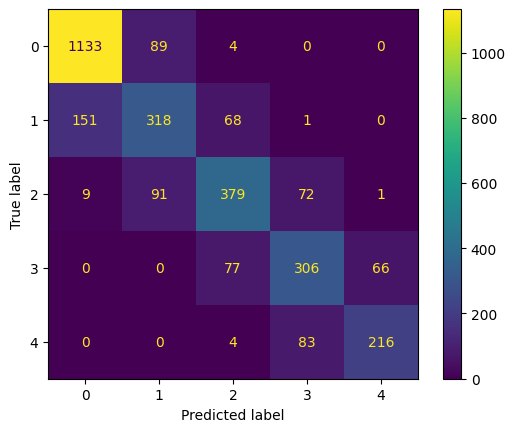

In [47]:
dnn_pred=model_clf.predict(X_test_scaled)

print("Final")
print_results(y_strat_test_set,dnn_pred)

## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
        "n_hidden": [1,2,3,4],
        "n_neurons": np.arange(60,90),
        "learning_rate":[0.005,0.01,0.02]
}

rs = RandomizedSearchCV(model_clf,param_distribs,n_iter=10, cv=3)
rs.fit(X_train_scaled, y_strat_train_set, epochs=100,batch_size=64,
                  validation_split=0.2,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10),lr_scheduler])

In [ ]:
best_dnn=rs.best_estimator_

In [ ]:
rs.best_params_

In [ ]:
best_dnn_pred=best_dnn.predict(X_test_scaled)

print("Final")
print_results(y_strat_test_set,best_dnn_pred)

# Regressione

## Train test split

In [ ]:
y_strat_train_set=strat_train_set["fwi"].copy()
y_strat_test_set=strat_test_set["fwi"].copy()

y_strat_train_set_danger=strat_train_set["danger"].copy()
y_strat_test_set_danger=strat_test_set["danger"].copy()

## Train

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [ ]:
def display_scores(set,prediction):
    print("RMSE Score:", np.sqrt(mean_squared_error(set,prediction)))
    print("MAE Score:",mean_absolute_error(set,prediction))
    print("R2 Score:", r2_score(set,prediction))

### Dummy

In [ ]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_scaled, y_strat_train_set) 

In [ ]:
dummy_predict = dummy_reg.predict(X_train_scaled)

In [ ]:
display_scores(y_strat_train_set,dummy_predict)

### Decision Tree

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_scaled,y_strat_train_set)

In [ ]:
tree_prediction = cross_val_predict(tree_reg, X_train_scaled, y_strat_train_set, cv=3)

In [ ]:
display_scores(y_strat_train_set,tree_prediction)

### Random Forest

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_scaled, y_strat_train_set)

In [ ]:
rf_prediction = cross_val_predict(rf_reg, X_train_scaled, y_strat_train_set, cv=3)

In [ ]:
display_scores(y_strat_train_set,rf_prediction)

### Extra Trees

In [ ]:
xtrees_reg=ExtraTreesRegressor(random_state=42)
xtrees_reg.fit(X_train_scaled, y_strat_train_set)

In [ ]:
xtree_prediction = cross_val_predict(xtrees_reg, X_train_scaled, y_strat_train_set,cv=3)

In [ ]:
display_scores(y_strat_train_set,xtree_prediction)

### XGB

In [ ]:
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train_scaled, y_strat_train_set)

In [ ]:
xgb_prediction=cross_val_predict(xgb_reg, X_train_scaled, y_strat_train_set, cv=3)

In [ ]:
display_scores(y_strat_train_set,xgb_prediction)

## GridSearch

### Extra Trees

In [ ]:
param_grid = [
        {'bootstrap':[True],'n_estimators': [200,300,400], 'max_depth': [30,40],'min_samples_split': [20,30]},  
]

xtrees_reg = ExtraTreesRegressor(random_state=42)

grid_search_xtree = GridSearchCV(xtrees_reg, param_grid, cv=3, 
                               scoring=("neg_root_mean_squared_error","r2"),refit="r2",
                               return_train_score=True,n_jobs=-1)

grid_search_xtree.fit(X_train_scaled, y_strat_train_set)

In [ ]:
best_xtrees=grid_search_xtree.best_estimator_
best_params=grid_search_xtree.best_params_
print("Parameters:",best_params)

In [ ]:
xtree_best_pred = cross_val_predict(best_xtrees, X_train_scaled, y_strat_train_set,cv=3,n_jobs=-1)

display_scores(y_strat_train_set,xtree_best_pred)

In [ ]:
feature_importance=best_xtrees.feature_importances_

importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
importance_df

### XGB

In [ ]:
param_grid={"learning_rate": [0.05,0.1],"max_depth": [5,10],"n_estimators":[100,200]}

xgb_reg = XGBRegressor(random_state=42)

grid_search_xgb = GridSearchCV(xgb_reg, param_grid, cv=3,scoring=("neg_root_mean_squared_error","r2"),refit="r2",    
                               return_train_score=True,n_jobs=-1)

grid_search_xgb.fit(X_train_scaled, y_strat_train_set)

In [ ]:
best_xgb=grid_search_xgb.best_estimator_

In [ ]:
xgb_best_pred = cross_val_predict(best_xgb, X_train_scaled, y_strat_train_set,cv=3,n_jobs=-1)

display_scores(y_strat_train_set,xgb_best_pred)

In [ ]:
feature_importance=best_xgb.feature_importances_

importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
importance_df

## Test

In [ ]:
def reg_to_class(pred):
    pred_clf=np.zeros_like(pred)
    
    pred_clf=[0 if 0<=i<=5 else 1 if 5<i<=10 else 2 if 10<i<=20
              else 3 if 20<i<=30 else 4 for i in pred]
    
    return pred_clf   

In [ ]:
best_xtrees_predict=best_xtrees.predict(X_test_scaled)

display_scores(y_strat_test_set,best_xtree_predict)

In [ ]:
best_xgb_predict=best_xgb.predict(X_test_scaled)

display_scores(y_strat_test_set,best_xgb_predict)

In [ ]:
pred_danger_xtree=reg_to_class(best_xtrees_predict)

print_results(y_strat_test_set_danger,pred_danger_xtree)

In [ ]:
pred_danger_xgb=reg_to_class(best_xgb_predict)

print_results(y_strat_test_set_danger,pred_danger_xgb)

# Neural Network

### First model

In [ ]:
root_logdir = os.path.join(os.curdir, "reg_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
es_scheduler=keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)

def build_model(n_hidden=2, n_neurons=90, learning_rate=0.01, input_shape=[12]):
    reg_model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        reg_model.add(keras.layers.Dense(n_neurons, activation="relu",kernel_initializer="normal", **options))
        options = {} 
    reg_model.add(keras.layers.Dense(1,activation="relu",**options))
    optimizer = keras.optimizers.legacy.SGD(learning_rate)
    reg_model.compile(loss=keras.losses.mean_absolute_error,metrics=["RootMeanSquaredError"], optimizer=optimizer)
    return reg_model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

history=keras_reg.fit(X_train_scaled, y_strat_train_set, epochs=100,
                  validation_split=0.2,
                  callbacks=[es_scheduler,lr_scheduler])

In [ ]:
keras_reg.model.summary()

In [ ]:
predicted_keras=keras_reg.predict(X_test_scaled)


display_scores(y_strat_test_set,predicted_keras)

In [ ]:
pred_danger=reg_to_class(predicted_keras)

print_results(y_strat_test_set_danger,pred_danger)

### Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
        "n_hidden": [1,2,3],
        "n_neurons": np.arange(60,80),
        "learning_rate":[0.01,0.05]
}

rs = RandomizedSearchCV(keras_reg,param_distribs,n_iter=10,scoring="neg_root_mean_squared_error", cv=3)
rs.fit(X_train_scaled, y_strat_train_set, epochs=100,batch_size=64,
                  validation_split=0.2,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10),lr_scheduler])

In [ ]:
rs.best_params_

In [ ]:
print("RMSE:",-rs.best_score_)

In [ ]:
best_nn_model = rs.best_estimator_.model

In [ ]:
best_nn_model.summary()

## Deployment

In [ ]:
X_train_new = X_strat_train_set.drop(['u10','v10'], axis=1)
X_test_new = X_strat_test_set.drop(['u10','v10'], axis=1)

X_train_new_scaled=pipeline.fit_transform(X_train_new)
X_test_new_scaled=pipeline.transform(X_test_new)

In [ ]:
xgb_model =best_xgb.fit(X_train_new_scaled, y_strat_train_set)

xgb_model_pred = xgb_model.predict(X_test_new_scaled)

display_scores(y_strat_test_set,xgb_model_pred)

In [ ]:
import bz2,pickle
file = bz2.BZ2File('regression.pkl','wb')
pickle.dump(xgb_model,file)
file.close()